In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten, concatenate, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model, model_to_dot
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle
import math


def build_rnn(X,lstm_layers,cells,output_size):
    model = Sequential()
    
    #model.add(Dense(units=cells,input_shape=(X.shape[1], X.shape[2])))
    for i in range(lstm_layers - 1):
        model.add(Bidirectional(LSTM(cells,activation='sigmoid',return_sequences=True)))
        model.add(Dropout(0.2))
        
    model.add(Bidirectional(LSTM(cells,activation='sigmoid')))
    model.add(Dropout(0.2))
    
    model.add(Dense(output_size, activation='softmax'))

    opt = Adam(learning_rate=0.00001)
    model.compile(loss = "mean_squared_error", metrics=['mean_squared_error'], optimizer = opt)
    return model

def build_cnn(X):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=21, activation='relu', input_shape=(4570, 1)))
    model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1,activation='relu'))
    opt = Adam(learning_rate=0.0000001)
    model.compile(loss = "mean_squared_error", metrics=['mean_squared_error'], optimizer = opt)
    return model

In [2]:
x = []
masses = []
rows = []
for file in listdir('E:/spectra/'):
    row = int(file.split('sp')[0])
    with open('E:/spectra/'+file,'rb') as rfile:
        sp = pickle.load(rfile)
    if len(sp[1]) >= 4570:
        flux = sp[1]/np.std(sp[1])
        diff = (len(sp[1]) - 4570)/2
        flux = flux[int(np.floor(diff)):int(np.floor(diff)+4570)]
        flux = flux.reshape(flux.shape[0],1)
        x.append(flux)
        rows.append(row)
    else:
        continue
x = np.array(x)

magnesiums =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_MgII'],header=0,squeeze=True)
carbons =  pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=['MBH_CIV'],header=0,squeeze=True)
masses = []
for i in rows:
    mag = magnesiums[i]
    car = carbons[i]
    if not math.isnan(mag) and not math.isnan(car):
        mass = 0.5*(mag+car)
    elif not math.isnan(mag):
        mass = mag
    elif not math.isnan(car):
        mass = car
    masses.append(mass)
y = np.array(masses)
y = (y - np.min(y))
y = y/np.max(np.abs(y))

In [4]:
model = build_rnn(x,1,50,1)

history = model.fit(x, y, epochs=10, verbose=1,batch_size=512, validation_split=0.2, shuffle=True)
#model.save(str('bot.h5'))

Epoch 1/10
9/9 [==============================] - 1370s 152s/step - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2375 - val_mean_squared_error: 0.2375
Epoch 2/10
9/9 [==============================] - 1435s 159s/step - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2375 - val_mean_squared_error: 0.2375
Epoch 3/10
9/9 [==============================] - 1518s 169s/step - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2375 - val_mean_squared_error: 0.2375
Epoch 4/10
9/9 [==============================] - 1570s 174s/step - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2375 - val_mean_squared_error: 0.2375
Epoch 5/10
7/9 [======================>.......] - ETA: 10:10 - loss: 0.2438 - mean_squared_error: 0.2438

KeyboardInterrupt: 

Text(0, 0.5, 'y_pred')

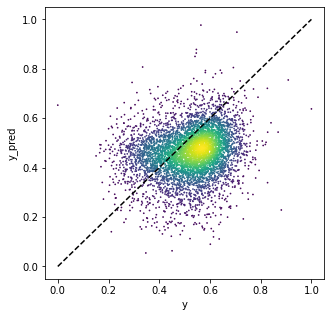

In [186]:
from scipy.stats import gaussian_kde

#y_pred = model.predict(x)
xy = np.vstack([y,[i[0] for i in y_pred]])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(5,5))
plt.scatter(y,y_pred,c=z,s=0.5)
plt.plot([0,1],[0,1],c='black',linestyle='dashed')
plt.xlabel('y')
plt.ylabel('y_pred')

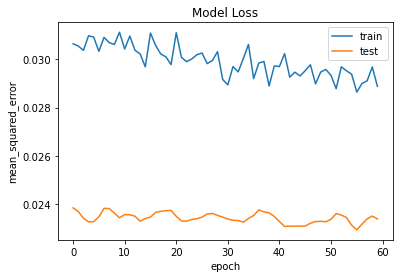

In [182]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [168]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 4569, 64)          192       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 4568, 64)          8256      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2284, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 146176)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 146176)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                7308850   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

(array([1.000e+00, 1.300e+01, 2.200e+02, 6.390e+02, 1.240e+03, 1.954e+03,
        1.176e+03, 1.710e+02, 1.000e+01, 2.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

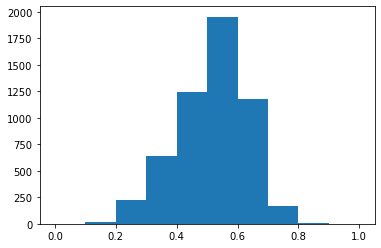

In [151]:
plt.hist(y)

In [ ]:
4570